In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from DomainPrediction.protein.base import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign
from DomainPrediction.utils.constants import *

In [4]:
root = '../..'
data_path = os.path.join(root, 'Data/al_acp_test')

In [5]:
df = pd.read_csv(os.path.join(data_path, 'ACP_AL_data.csv'))

In [6]:
df.head()

,Seq,Block,Titer
0,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ATAATTBB,1.528668
1,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-TATTTTAB,0.809306
2,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-TTTTBTBA,0.932477
3,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ATTBAATB,0.595051
4,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ABTATTTA,0.917234


In [7]:
df.shape, len(df['Seq'][0])

((96, 3), 663)

In [8]:
AHR_domain = "NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWGADDKQVKAVIGDLTSKNLGIDAKTLKSLKGNIDHVFHLAAVYDMGADEEAQAATNIEGTRAAVQAAEAMGAKHFHHVSSIAAAGLFKGIFREDMFEEAEKLDHPYLRTKHESEKVVREECKVPFRIYRPGMVIGHSETGEMDKVDGPYYFFKMIQKIRHALPQWVPTIGIEGGRLNIVPVDFVVDALDHIAHLEGEDGNCFHLVDSDPYKVGEILNIFCEAGHAPRMGMRIDSRMFGFIPPFIRQSIKNLPPVKRITGALLDDMGIPPSVMSFINYPTRFDTRELERVLKGTDIEVPRLPSYAPVIWDY"
len(AHR_domain)

355

In [9]:
## Sanity check
for seq in df['Seq']:
    if AHR_domain in seq:
        assert seq.find(AHR_domain) == 0
    else:
        print(seq)

In [10]:
## Removing AHR
variable_seq = []
for seq in df['Seq']:
    variable_seq.append(seq.replace(AHR_domain, ''))

In [11]:
df['trimmed_seq'] = variable_seq

In [12]:
df.head()

,Seq,Block,Titer,trimmed_seq
0,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ATAATTBB,1.528668,WERNLDPDLFKDRTLKGTVEGKVCVVTGGSSGIGLAAACKFAEAGA...
1,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-TATTTTAB,0.809306,WERNLDPDLFIDRSLRGTVGGKVVLVTGATSGIGLATAEKLAEAGA...
2,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-TTTTBTBA,0.932477,WERNLDPDLFIDRSLRGTVGGKVVLVTGGSSGIGLAAACKFAEAGA...
3,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ATTBAATB,0.595051,WERNLDPDLFKDRTLKGTVEGKVCVVTGGSSGIGLAAACKFAEAGA...
4,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ABTATTTA,0.917234,WERNLDPDLFKDRTLKGTVEGKVCVVTGATSGIGLATAEKLADAGA...


In [13]:
from DomainPrediction.esm.esm2 import ESM2

In [14]:
esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt')

In [15]:
def get_embeddings(sequences):
    embeddings = []
    for seq in tqdm(sequences):
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

In [16]:
embeddings = get_embeddings(df['trimmed_seq'])

100%|██████████| 96/96 [02:08<00:00,  1.34s/it]


In [17]:
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [18]:
# surrogate = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0,
                                max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
                                n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0,
                                max_samples=None)

<Axes: >

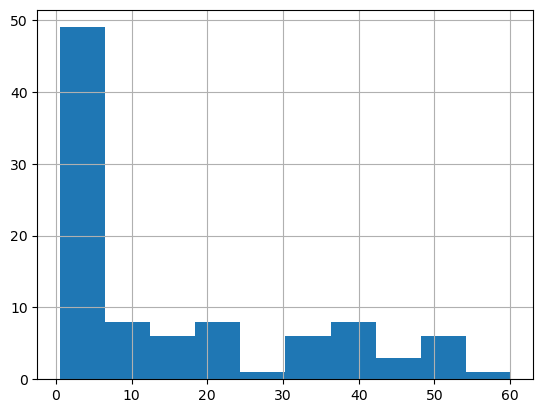

In [51]:
df['Titer'].hist()

samples remaining: 96


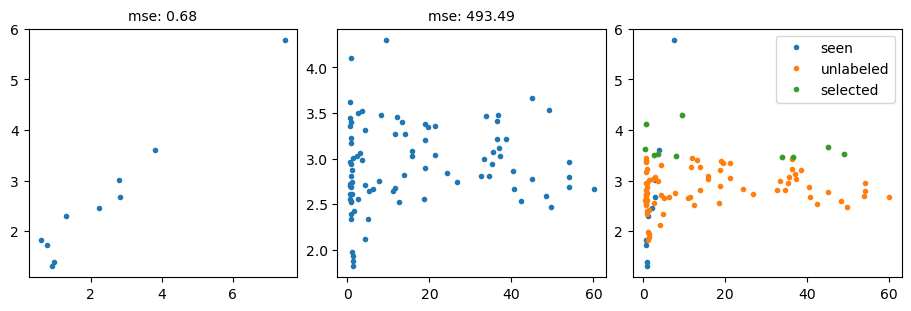

samples remaining: 86


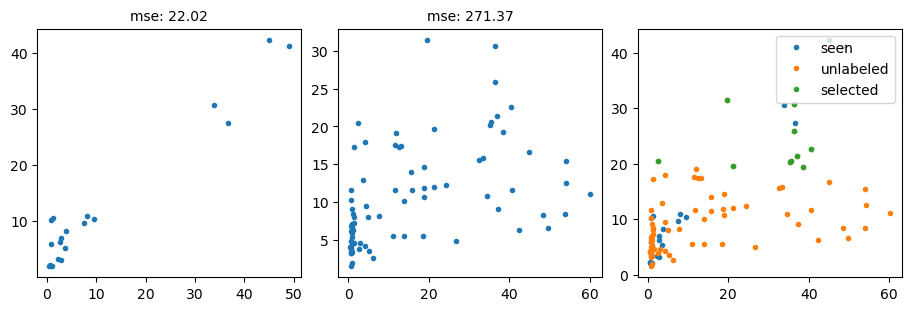

samples remaining: 76


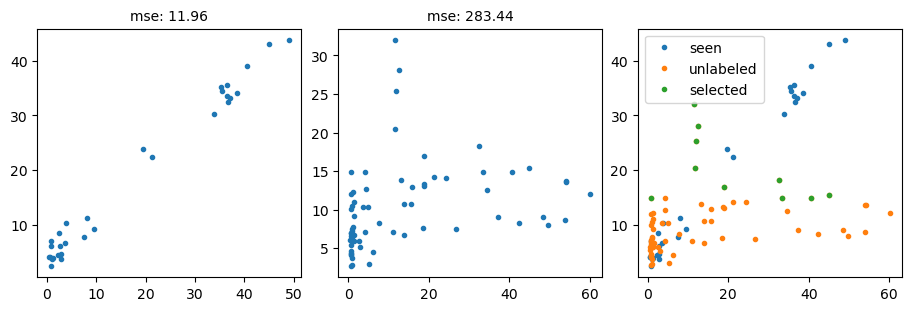

samples remaining: 66


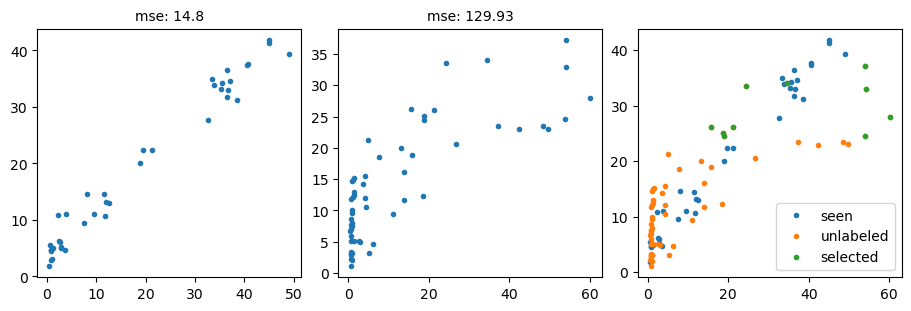

samples remaining: 56


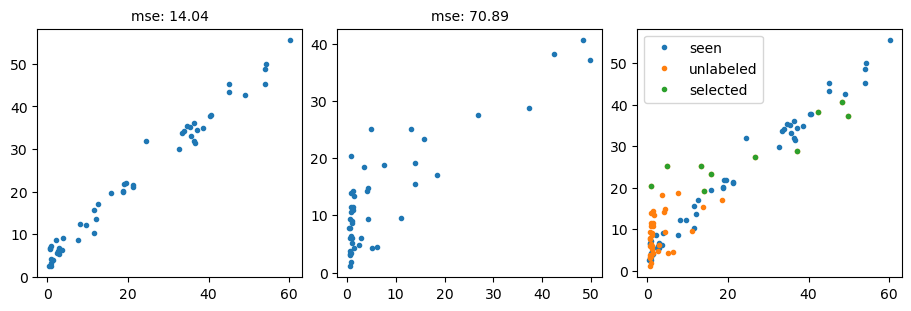

In [55]:
df_al = df.copy()
df_al['round'] = 0

rounds = 5
n_sample = 10
thresh = 10
index = list(df_al.loc[(df_al['round'] == 0) & (df_al['Titer'] < thresh)].index)
sample_index = random.sample(index, n_sample)
for i in range(rounds):
    print(f"samples remaining: {(df_al['round'] == 0).sum()}")
    df_al.loc[sample_index, 'round'] = i+1 

    train_index = list(df_al.loc[df_al['round'] != 0].index)
    x = embeddings[train_index]
    y = df_al.loc[train_index, 'Titer'].to_numpy()
    _ = model.fit(x, y)
    ypred = model.predict(embeddings)
    df_al[f'round_{i+1}_pred'] = ypred
    
    fig, ax = plt.subplots(1,3, figsize=(9,3), layout='constrained')
    ax[0].plot(df_al.loc[train_index, 'Titer'], df_al.loc[train_index, f'round_{i+1}_pred'], '.')
    mse = mean_squared_error(df_al.loc[train_index, 'Titer'], df_al.loc[train_index, f'round_{i+1}_pred'])
    ax[0].set_title(f'mse: {round(mse, 2)}', size=10)
    ax[1].plot(df_al.loc[df_al['round']==0, 'Titer'], df_al.loc[df_al['round']==0, f'round_{i+1}_pred'], '.')
    mse = mean_squared_error(df_al.loc[df_al['round']==0, 'Titer'], df_al.loc[df_al['round']==0, f'round_{i+1}_pred'])
    ax[1].set_title(f'mse: {round(mse, 2)}', size=10)

    sample_index = df_al.loc[df_al['round']==0, f'round_{i+1}_pred'].nlargest(n_sample).index

    ax[2].plot(df_al.loc[train_index, 'Titer'], df_al.loc[train_index, f'round_{i+1}_pred'], '.', label='seen')
    ax[2].plot(df_al.loc[df_al['round']==0, 'Titer'], df_al.loc[df_al['round']==0, f'round_{i+1}_pred'], '.', label='unlabeled')
    ax[2].plot(df_al.loc[sample_index, 'Titer'], df_al.loc[sample_index, f'round_{i+1}_pred'], '.', label='selected')
    ax[2].legend()
    plt.show()

In [56]:
df_al

,Seq,Block,Titer,trimmed_seq,round,round_1_pred,round_2_pred,round_3_pred,round_4_pred,round_5_pred
0,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ATAATTBB,1.528668,WERNLDPDLFKDRTLKGTVEGKVCVVTGGSSGIGLAAACKFAEAGA...,0,2.425641,4.600338,6.769130,15.251494,13.340184
1,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-TATTTTAB,0.809306,WERNLDPDLFIDRSLRGTVGGKVVLVTGATSGIGLATAEKLAEAGA...,0,2.521136,11.640694,12.071368,11.764018,13.861444
2,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-TTTTBTBA,0.932477,WERNLDPDLFIDRSLRGTVGGKVVLVTGGSSGIGLAAACKFAEAGA...,0,2.944368,6.893511,6.180249,10.004891,10.661946
3,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ATTBAATB,0.595051,WERNLDPDLFKDRTLKGTVEGKVCVVTGGSSGIGLAAACKFAEAGA...,1,1.823924,2.267835,4.069208,5.503660,6.761410
4,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ABTATTTA,0.917234,WERNLDPDLFKDRTLKGTVEGKVCVVTGATSGIGLATAEKLADAGA...,0,2.342368,1.916207,2.893638,2.024181,1.820852
...,...,...,...,...,...,...,...,...,...,...
91,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-ABBBAAAB,35.281228,WERNLDPDLFKDRTLKGTVEGKVCVVTGATSGIGLATAEKLADAGA...,3,2.944579,20.213069,35.147344,33.196471,35.204471
92,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-BTBBATAB,34.566492,WERNLDPDLFKDRTLRGTVEGKVCVVTGGSSGIGLAAACKFAEAGA...,5,2.812147,10.865997,12.551131,34.088505,35.397070
93,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-AAAAAAAA,11.079517,WERNLDPDLFKDRTLKGTVEGKVCVVTGATSGIGLATAEKLAEAGA...,0,2.648277,5.548598,7.085767,9.487328,9.489539
94,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,A-BBBBBBBB,36.675911,WERNLDPDLFKDRTLRGTVEGKVCVVTGATSGIGLATAEKLADAGA...,2,3.473472,27.407877,32.433407,33.005252,31.430782


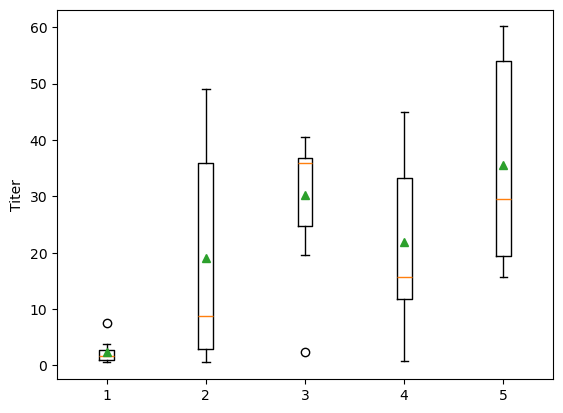

In [58]:
fig, ax = plt.subplots()
ax.set_ylabel('Titer')
for i, _round in enumerate([1, 2, 3, 4, 5]):
    ax.boxplot(df_al.loc[df_al['round']==_round, 'Titer'], positions=[i], labels=[_round], showmeans=True)

In [ ]:
## Matern 5 2